In [1]:
import pandas
import numpy as np
import ROOT
ROOT.gROOT.SetBatch(True)
ROOT.TH1.SetDefaultSumw2(True)
from IPython.html.widgets import interact
import scipy
import sys
sys.path.append("/Users/joosep/Documents/heplot")
sys.path.append("/Users/joosep/Documents/btv/SuperTagger/python")
import heplot
import rootpy
import os
%matplotlib inline
from matplotlib import pyplot as plt
from supertagger_train import root2array

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
from copy import deepcopy

In [3]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [4]:
# tf = ROOT.TFile("SuperTagger/outputs/TMVAMultiClass_cls2.root")
# tt1 = tf.Get("TestTree")
# tt2 = tf.Get("TrainTree")

# ROOT.gROOT.cd()
# tt1.Draw("bd_csv_avf >> htest(60,0,1)")
# tt2.Draw("bd_csv_avf >> htrain(60,0,1)")
# tf.Close()

In [5]:
# h1 = rootpy.asrootpy(ROOT.gROOT.Get("htest"))
# h2 = rootpy.asrootpy(ROOT.gROOT.Get("htrain"))

In [6]:
# plt.figure(figsize=(8,8))
# heplot.barhist(h1, lw=2)
# heplot.barhist(h2, color="red", lw=2)

In [89]:
def load_classifications(fn):
    a1 = root2array(fn + ".root", "TestTree",
        colnames=["classID", "csv1", "csv2", "pt", "eta", "flavour"]
    )
    a2 = root2array(fn + ".root", "TrainTree",
        colnames=["classID", "csv1", "csv2", "pt", "eta", "flavour"]
    )
    b1 = root2array(fn + "_test.root", "tree",
        colnames=["b"]
    )
    b2 = root2array(fn + "_train.root", "tree",
        colnames=["b"]
    )
    
    d1 = pandas.DataFrame(np.hstack((a1, b1)), columns=["cl", "csv1", "csv2", "pt", "eta", "flavour", "pb"])
    d2 = pandas.DataFrame(np.hstack((a2, b2)), columns=["cl", "csv1", "csv2", "pt", "eta", "flavour", "pb"])
    d1["type"] = int(0)
    d2["type"] = int(1)
    
    d = d1.append(d2, ignore_index=True)
    d["cls"] = 0
    if "_cls2_" in fn:
        d["cls"] = 1
    return d

In [105]:
import glob
ds = glob.glob("outputs/*test.root")
ds = filter(lambda x: os.path.isfile(x.replace("test", "train")), ds)

In [106]:
len(ds)

730

In [107]:
dss = [load_classifications(x[:x.find("_test")]) for x in ds]

In [108]:
d1 = dss[0]
for i in range(1, len(dss)):
    
    d1 = d1.append(dss[i], ignore_index=True)
d1.shape

(9669596, 9)

In [146]:
d1["abs_flavour"] = map(int, abs(d1["flavour"]))
d1.ix[d1["abs_flavour"]<4, "abs_flavour"] = int(0)
d1.ix[d1["abs_flavour"]==21, "abs_flavour"] = int(0)

In [147]:
d1_cls1 = d1[d1["cls"]==0]
d1_cls2 = d1[d1["cls"]==1]

In [148]:
d1_cls1_pt0 = d1_cls1[d1_cls1["pt"]<30]
d1_cls1_pt1 = d1_cls1[(d1_cls1["pt"]>=30) & (d1_cls1["pt"]<40)]
d1_cls1_pt2 = d1_cls1[(d1_cls1["pt"]>=40) & (d1_cls1["pt"]<50)]
d1_cls1_pt3 = d1_cls1[(d1_cls1["pt"]>=50) & (d1_cls1["pt"]<60)]
d1_cls1_pt4 = d1_cls1[(d1_cls1["pt"]>=60) & (d1_cls1["pt"]<70)]
d1_cls1_pt5 = d1_cls1[(d1_cls1["pt"]>=70) & (d1_cls1["pt"]<80)]
d1_cls1_pt6 = d1_cls1[(d1_cls1["pt"]>=80) & (d1_cls1["pt"]<90)]
d1_cls1_pt7 = d1_cls1[(d1_cls1["pt"]>=90) & (d1_cls1["pt"]<100)]

In [111]:
def calc_rocs(d1):
    bs_train = abs(d1[d1["type"]==1]["flavour"]) == 5.0
    bs_test = abs(d1[d1["type"]==0]["flavour"]) == 5.0
    r1b_train = roc_curve(bs_train, d1[d1["type"]==1]["pb"])
    r1csv1_train = roc_curve(bs_train, d1[d1["type"]==1]["csv1"])
    r1csv2_train = roc_curve(bs_train, d1[d1["type"]==1]["csv2"])

    r1b_test = roc_curve(bs_test, d1[d1["type"]==0]["pb"])
    r1csv1_test = roc_curve(bs_test, d1[d1["type"]==0]["csv1"])
    r1csv2_test = roc_curve(bs_test, d1[d1["type"]==0]["csv2"])

    return [r1b_train, r1csv1_train, r1csv2_train, r1b_test, r1csv1_test, r1csv2_test]

In [112]:
rs1 = calc_rocs(d1_cls1)
rs2 = calc_rocs(d1_cls2)

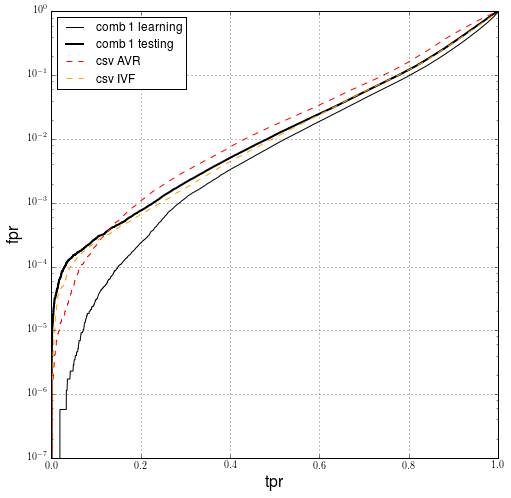

In [315]:
plt.figure(figsize=(8,8))
plt.grid()
plt.plot(rs1[0][1], rs1[0][0], label="comb 1 learning", ls="-", color="black")
plt.plot(rs1[3][1], rs1[3][0], label="comb 1 testing", ls="-", color="black", lw=2)
plt.plot(rs1[4][1], rs1[4][0], label="csv AVR", ls="--", color="red")
plt.plot(rs1[5][1], rs1[5][0], label="csv IVF", ls="--", color="orange")

#plt.plot(rs2[0][1], rs2[0][0], label="comb 2 L", ls="--", color="green")
#plt.plot(rs2[3][1], rs2[3][0], label="comb 2 T", ls="-.", color="green", lw=2)
#plt.plot(rs2[5][1], rs2[5][0], label="cls2 csv", ls="-", color="green")

#plt.plot(rs2[3][1], rs2[3][0], label="cls2")
#plt.plot(rs2[5][1], rs2[5][0], label="cls2", ls="--")
plt.xlabel("tpr", fontsize=16)
plt.ylabel("fpr", fontsize=16)
plt.yscale("log")
plt.legend(loc=2)
#plt.ylim(0.1, 1.0)

In [ ]:
dss_cls1 = filter(lambda x: "_cls1_" in x.fn[0], dss)

In [ ]:
plt.hist([auc_diff(dss_cls1[i]) for i in range(len(dss_cls1))], bins=50)
plt.yscale("log")

In [ ]:
def auc_diff(d):
    r1 = roc_auc_score(d["cl"]==0, d["csv1"])
    r2 = roc_auc_score(d["cl"]==0, d["csv2"])
    return r1-r2

In [114]:
def draw_roc(d1):
    
    d1 = d1[d1["type"]==0]
    d_lb = d1[abs(d1["flavour"])!=4]
    d_cb = d1[(abs(d1["flavour"]) == 4) | (abs(d1["flavour"]) == 5)]
    print (d_lb.shape)
    r1b_test = roc_curve(abs(d_lb["flavour"])==5, d_lb["pb"])
    r1csv1_test = roc_curve(abs(d_lb["flavour"])==5, d_lb["csv1"])
    r1csv2_test = roc_curve(abs(d_lb["flavour"])==5, d_lb["csv2"])

    r2b_test = roc_curve(abs(d_cb["flavour"])==5, d_cb["pb"])
    r2csv1_test = roc_curve(abs(d_cb["flavour"])==5, d_cb["csv1"])
    r2csv2_test = roc_curve(abs(d_cb["flavour"])==5, d_cb["csv2"])

    r3b_test = roc_curve(abs(d1["flavour"])==5, d1["pb"])
    r3csv1_test = roc_curve(abs(d1["flavour"])==5, d1["csv1"])
    r3csv2_test = roc_curve(abs(d1["flavour"])==5, d1["csv2"])

                                                        
    plt.figure(figsize=(18, 6))
    ax1 = plt.subplot(1,3,1)
    #plt.plot(r1b_train[1], r1b_train[0], color="black", label="cls1", lw=1, ls="--")
    #plt.plot(r1csv1_train[1], r1csv1_train[0], color="green", label="csv1", ls="--")
    #plt.plot(r1csv2_train[1], r1csv2_train[0], color="blue", label="csv2", ls="--")

    plt.plot(r1b_test[1], r1b_test[0], color="black", label="cls1", lw=2)
    #plt.plot(r1b_test2[1], r1b_test2[0], color="gray", label="cls12", lw=2)
    plt.plot(r1csv1_test[1], r1csv1_test[0], color="green", label="csv1", ls="--")
    plt.plot(r1csv2_test[1], r1csv2_test[0], color="blue", label="csv2", ls="--")
    
    plt.grid()
    plt.xlabel("tpr", fontsize=16)
    plt.ylabel("fpr (udsg)", fontsize=16)
    plt.yscale("log")
    plt.legend(loc=2)
    plt.ylim(0.00001, 1.0)

    ax2 = plt.subplot(1,3,2)
    plt.plot(r2b_test[1], r2b_test[0], color="black", label="cls1", lw=2)
    #plt.plot(r2b_test2[1], r2b_test2[0], color="gray", label="cls12", lw=2)
    plt.plot(r2csv1_test[1], r2csv1_test[0], color="green", label="csv1", ls="--")
    plt.plot(r2csv2_test[1], r2csv2_test[0], color="blue", label="csv2", ls="--")
    
    plt.grid()
    plt.xlabel("tpr", fontsize=16)
    plt.ylabel("fpr (c)", fontsize=16)
    plt.ylim(0.00001, 1.0)
    plt.yscale("log")
    
    ax2 = plt.subplot(1,3,3)
    plt.plot(r3b_test[1], r3b_test[0], color="black", label="combined", lw=2)
    #plt.plot(r3b_test2[1], r3b_test2[0], color="gray", label="cls12", lw=2)
    plt.plot(r3csv1_test[1], r3csv1_test[0], color="green", label="CSV IVF", ls="--")
    plt.plot(r3csv2_test[1], r3csv2_test[0], color="blue", label="CSV AVR", ls="--")
    
    plt.grid()
    plt.xlabel("tpr", fontsize=16)
    plt.ylabel("fpr (udsgc)", fontsize=16)
    plt.ylim(0.00001, 1.0)
    plt.yscale("log")

(83284, 10)


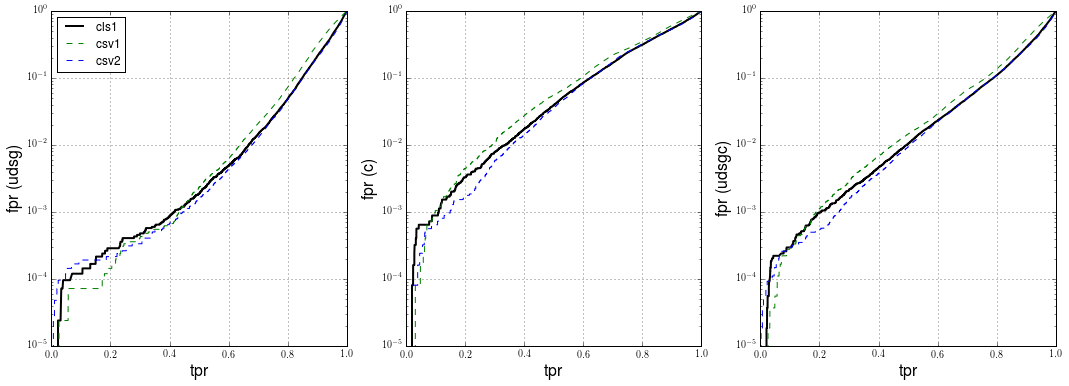

In [308]:
draw_roc(d1_cls1_pt7)

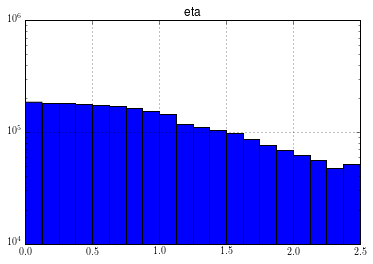

In [166]:
d1_cls1.hist("eta", bins=np.linspace(0, 2.5, 21))
plt.yscale("log")

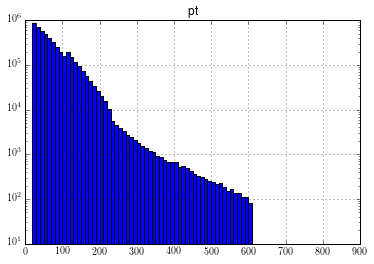

In [175]:
d1_cls1.hist("pt", bins=np.linspace(20, 820, 81))
plt.yscale("log")

In [117]:
hs = np.histogram2d(
    d1_cls1["pt"], np.abs(d1_cls1["eta"]),
    bins=(np.linspace(20, 820, 81), np.linspace(0, 2.5, 21))
)

<matplotlib.colorbar.Colorbar instance at 0x11678e3b0>

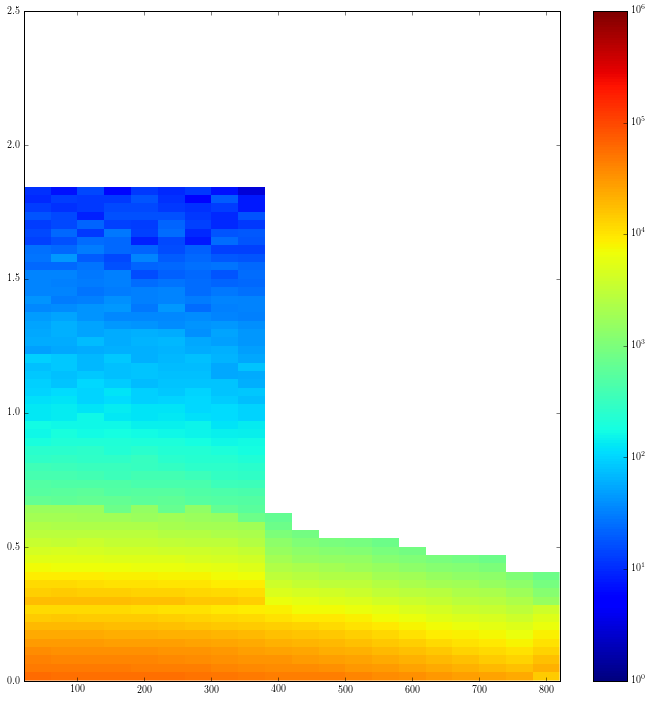

In [120]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(12,12))
ax = plt.axes()
#plt.xlim(20,820)
#plt.ylim(0,2.4)
plt.imshow(
    hs[0],
    extent=(min(hs[1]), max(hs[1]), min(hs[2]), max(hs[2])),
    interpolation="none", origin="lower", aspect="auto",
    norm=LogNorm(vmin=1, vmax=1000000)
)
plt.colorbar()

In [138]:
gs

abs_flavour
0    ([2032956, 1500020, 766050, 355548, 203394, 13...
4    ([285660, 246668, 152938, 101798, 76434, 63336...
5    ([196464, 200740, 156190, 130218, 127934, 1374...
dtype: object

In [139]:
gs.keys()

Float64Index([0.0, 4.0, 5.0], dtype='float64')

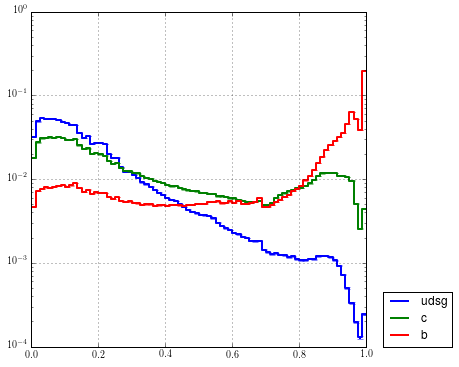

In [302]:
g = d1.groupby("abs_flavour")

gs = g.apply(
    lambda x: np.histogram(
        x["csv1"],
        bins=np.linspace(0, 1, 81),
    )
)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
heplot.grouped_histograms_sameax(gs, keynames=["udsg", "c", "b"], ax=ax, scaling="normalize")
plt.legend(loc=(1.05, 0.0))
plt.grid();
plt.yscale("log")

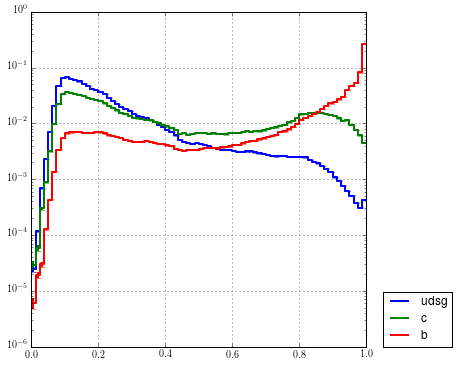

In [301]:
g = d1.groupby("abs_flavour")

gs = g.apply(
    lambda x: np.histogram(
        x["csv2"],
        bins=np.linspace(0, 1, 81)
    )
)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
heplot.grouped_histograms_sameax(gs, keynames=["udsg", "c", "b"], ax=ax, scaling="normalize")
plt.legend(loc=(1.05, 0.0))
plt.grid();
plt.yscale("log")

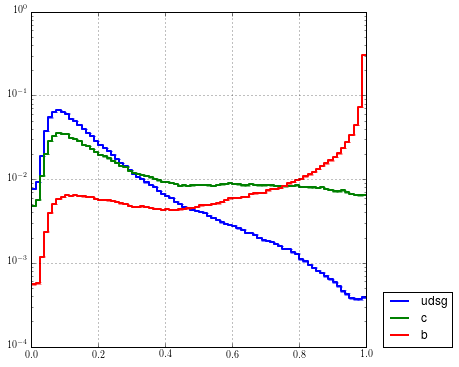

In [300]:
g = d1.groupby("abs_flavour")

gs = g.apply(
    lambda x: np.histogram(
        x["pb"],
        bins=np.linspace(0, 1, 81)
    )
)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
heplot.grouped_histograms_sameax(gs, keynames=["udsg", "c", "b"], ax=ax, scaling="normalize")
plt.legend(loc=(1.05, 0.0))
plt.grid();
plt.yscale("log")

In [255]:
def hist_chi2(h1, h2):
    I1 = float(np.sum(h1[0]))
    I2 = float(np.sum(h2[0]))
    return np.sum(np.power(h1[0]/I1 - h2[0]/I2, 2) / (h1[0]/I1**2 + h2[0]/I2**2)) / (len(h1[1])-1)

In [256]:
def hist_kolm(h1, h2):
    I1 = float(np.sum(h1[0]))
    I2 = float(np.sum(h2[0]))
    return np.min(np.abs(np.cumsum(h1[0]/I1) - np.cumsum(h2[0]/I2)))

In [328]:
def draw_discriminator(d, name):
    g1 = d[d["type"]==0].groupby("abs_flavour")
    g2 = d[d["type"]==1].groupby("abs_flavour")

    gs1 = g1.apply(
        lambda x: np.histogram(
            x[name],
            bins=np.linspace(0, 1, 41)
        )
    )

    gs2 = g2.apply(
        lambda x: np.histogram(
            x[name],
            bins=np.linspace(0, 1, 41)
        )
    )

    fig = plt.figure(figsize=(8,8))
    ax1 = plt.subplot(2,1,1)
    heplot.grouped_histograms_sameax(gs1, keynames=["udsg T", "c T", "b T"], ax=ax1, scaling="normalize")
    ax1.set_color_cycle(None)
    heplot.grouped_histograms_sameax(gs2, keynames=["udsg L", "c L", "b L"], ax=ax1, ls="-.", scaling="normalize")
    plt.legend(loc=(1.05,0.0))
    plt.grid()
    plt.yscale("log")
    ax2 = plt.subplot(2,1,2)
    for k in gs1.keys():
        print hist_chi2(gs1[k], gs2[k]), hist_kolm(gs1[k], gs2[k])
    for k in gs1.keys():
        h1 = gs1[k][0]
        h2 = gs2[k][0]
        I1 = float(np.sum(h1))
        I2 = float(np.sum(h2))
        gs1[k] = ((h2/I2) / map(float, h1/I1), gs2[k][1])
    ax2.set_color_cycle(None)
    heplot.grouped_histograms_sameax(gs1, keynames=["udsg", "c", "b"], ax=ax2, ls="-", errors=False)
    plt.ylabel("learning / testing ratio")
    plt.ylim(0.75, 1.25)
    plt.grid()

In [336]:
def draw_discriminator_cumulative(d, name):
    g1 = d[d["type"]==0].groupby("abs_flavour")
    g2 = d[d["type"]==1].groupby("abs_flavour")

    def cumhist(x):
        h = np.histogram(
            x[name],
            bins=np.linspace(0, 1, 41)
        )
        return (np.cumsum(h[0])/float(np.sum(h[0])), h[1], 0.0*h[0])
    
    gs1 = g1.apply(
        cumhist
    )

    gs2 = g2.apply(
        cumhist
    )

    fig = plt.figure(figsize=(8,16))
    ax1 = plt.subplot(2,1,1)
    grouped_histograms_sameax(gs1, keynames=["udsg T", "c T", "b T"], ax=ax1, errors=False)
    ax1.set_color_cycle(None)
    grouped_histograms_sameax(gs2, keynames=["udsg L", "c L", "b L"], ax=ax1, ls="-.", errors=False)
    plt.legend(loc=(1.05,0.0))
    plt.grid()

    ax2 = plt.subplot(2,1,2)
    for k in gs1.keys():
        print hist_chi2(gs1[k], gs2[k]), hist_kolm(gs1[k], gs2[k])
    for k in gs1.keys():
        h1 = gs1[k][0]
        h2 = gs2[k][0]
        I1 = float(np.sum(h1))
        I2 = float(np.sum(h2))
        gs1[k] = ((h2/I2) / map(float, h1/I1), gs2[k][1])
    ax2.set_color_cycle(None)
    grouped_histograms_sameax(gs1, keynames=["udsg", "c", "b"], ax=ax2, ls="-", errors=False)
    plt.ylabel("learning / testing ratio")
    plt.ylim(0.75, 1.25)
    plt.grid()

95.2734036638 1.11022302463e-16
9.22004005729 1.11022302463e-16
3.78044028299 0.0


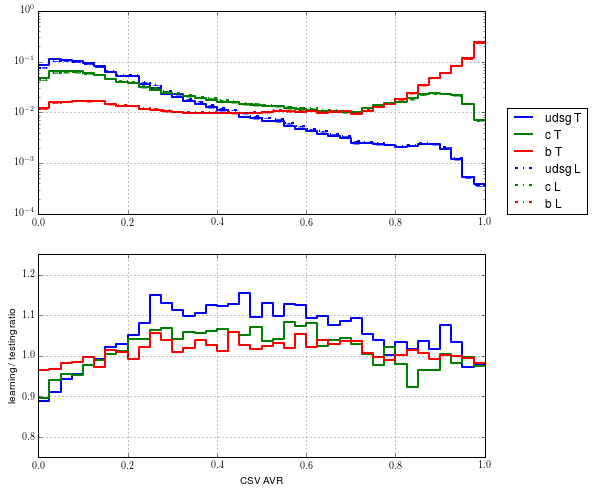

In [292]:
draw_discriminator(d1_cls1, "csv1");
plt.xlabel("CSV AVR")

64.3809393798 2.22044604925e-16
5.3352283371 3.33066907388e-16
2.82913040956 0.0


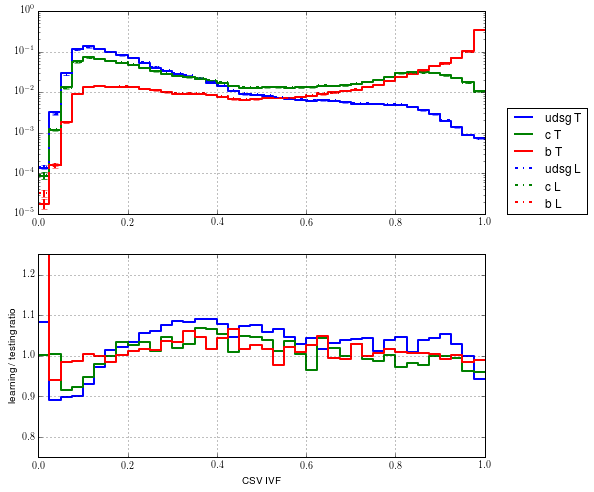

In [293]:
draw_discriminator(d1_cls1, "csv2")
plt.xlabel("CSV IVF")

112.897240799 2.22044604925e-16
66.6277974908 1.11022302463e-16
263.003867948 2.22044604925e-16


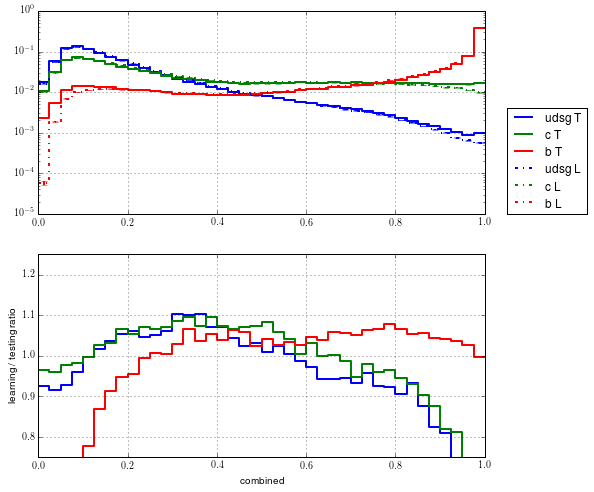

In [294]:
draw_discriminator(d1, "pb")
plt.xlabel("combined")

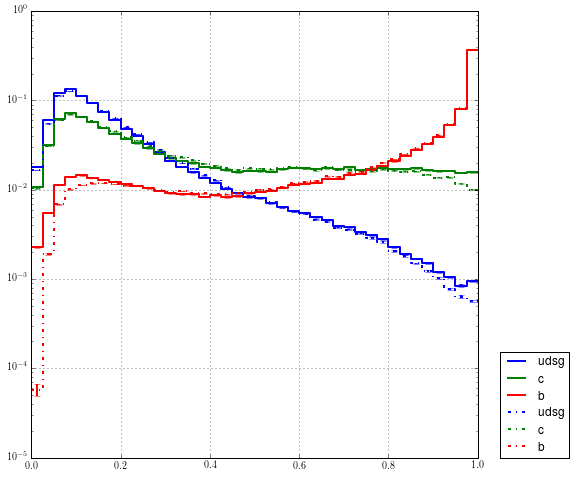

In [162]:
draw_discriminator(d1_cls1, "pb")

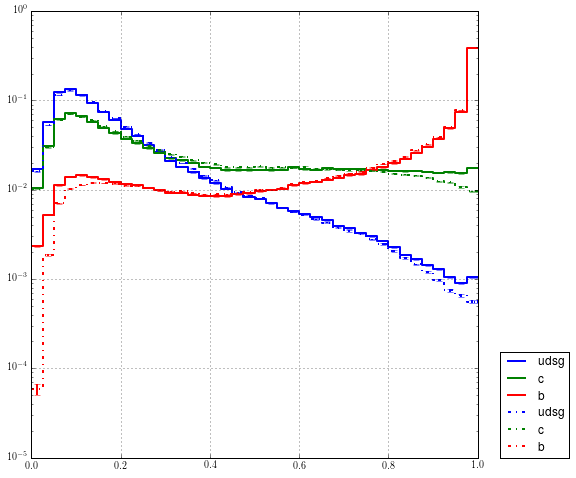

In [163]:
draw_discriminator(d1_cls2, "pb")

7.0444352859e-05 0.0
4.18018667148e-05 0.0
0.000886395024509 1.11022302463e-16


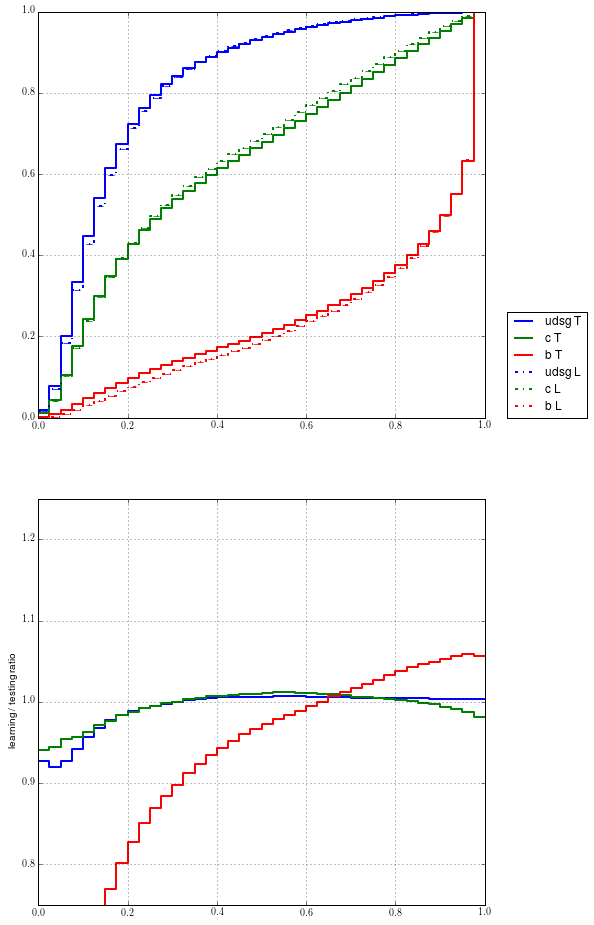

In [337]:
draw_discriminator_cumulative(d1_cls1, "pb")

0.000109822288061 2.22044604925e-16
3.7086570331e-05 3.33066907388e-16
4.38587983611e-06 2.22044604925e-16


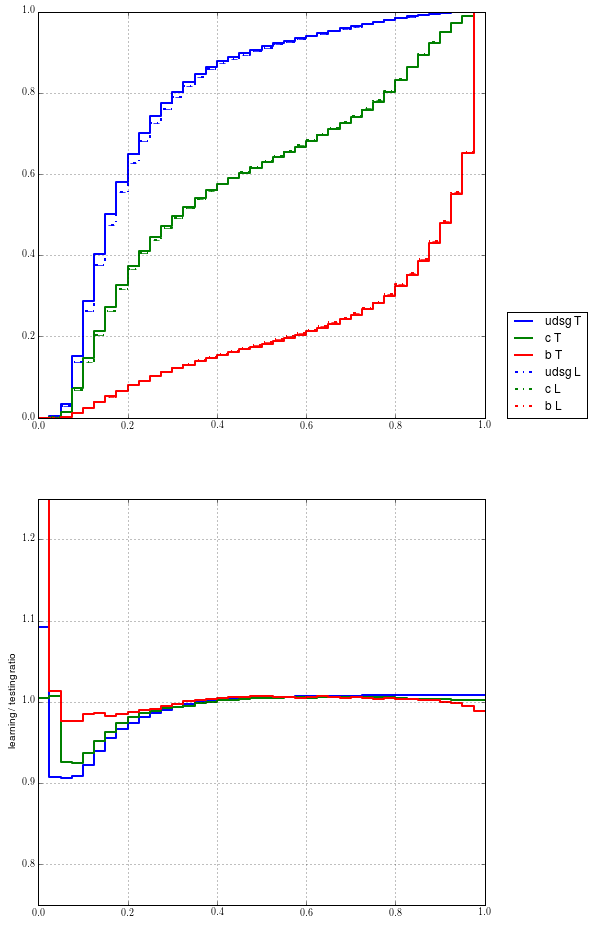

In [338]:
draw_discriminator_cumulative(d1_cls1, "csv2")

In [354]:
d = d1_cls1_pt0
name = "csv2"
g1 = d[d["type"]==0].groupby("abs_flavour")
g2 = d[d["type"]==1].groupby("abs_flavour")

def cumhist(x):
    h = np.histogram(
        x[name],
        bins=np.linspace(0, 1, 41)
    )
    return (np.cumsum(h[0])/float(np.sum(h[0])), h[1], 0.0*h[0])

gs11 = g1.apply(
    cumhist
)

gs21 = g2.apply(
    cumhist
)

name = "pb"

def cumhist(x):
    h = np.histogram(
        x[name],
        bins=np.linspace(0, 1, 41)
    )
    return (np.cumsum(h[0])/float(np.sum(h[0])), h[1], 0.0*h[0])

gs12 = g1.apply(
    cumhist
)

gs22 = g2.apply(
    cumhist
)

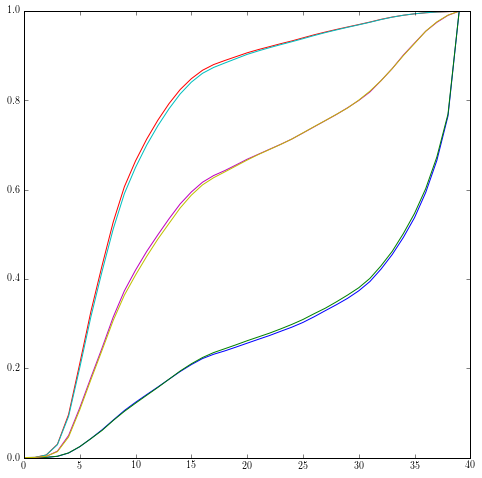

In [356]:
plt.figure(figsize=(8,8))
plt.plot(gs11[5][0])
plt.plot(gs21[5][0])

plt.plot(gs11[0][0])
plt.plot(gs21[0][0])

plt.plot(gs11[4][0])
plt.plot(gs21[4][0])